In this notebook we have Housing Values in Suburbs in Boston and the goal is to come up with the model to predict median value of given house in the area. We will have hands on linear regression and ...


### IMPORTING LIBRARIES

In [5]:
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext


In [ ]:
sc = SparkContext()
sqlContext = SQLContext(sc)

### Loading data

In [7]:

house_df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('boston_data.csv')
house_df.take(1)

[Row(crim=0.15876, zn=0.0, indus=10.81, chas=0.0, nox=0.413, rm=5.961, age=17.5, dis=5.2873, rad=4.0, tax=305.0, ptratio=19.2, black=376.94, lstat=9.88, medv=21.7)]

In [8]:
house_df.cache()

DataFrame[crim: double, zn: double, indus: double, chas: double, nox: double, rm: double, age: double, dis: double, rad: double, tax: double, ptratio: double, black: double, lstat: double, medv: double]

In [9]:
house_df.printSchema()

root
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: double (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: double (nullable = true)
 |-- tax: double (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- black: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)



SCEHMA IN TREE FORMAT MENTIONED ABOVE

### Descriptive Analysis

In [10]:
house_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
crim,404,3.7309119306930723,8.943922212251913,0.00632,88.9762
zn,404,10.509900990099009,22.053733184762923,0.0,95.0
indus,404,11.189900990099002,6.8149093223650885,0.46,27.74
chas,404,0.06930693069306931,0.25429026389960196,0.0,1.0
nox,404,0.5567103960396043,0.11732064984156548,0.392,0.871
rm,404,6.301450495049499,0.6758302935149543,3.561,8.78
age,404,68.60173267326732,28.066142579151702,2.9,100.0
dis,404,3.7996663366336647,2.1099159643057357,1.1691,12.1265
rad,404,9.836633663366337,8.834741064787444,1.0,24.0


Finding the correlation between independent variables and target variables.

In [12]:
import six
for i in house_df.columns:
    if not( isinstance(house_df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to MEDV for ", i, house_df.stat.corr('medv',i))

Correlation to MEDV for  crim -0.4009558757372438
Correlation to MEDV for  zn 0.355607582415516
Correlation to MEDV for  indus -0.5016982293419979
Correlation to MEDV for  chas 0.14140044808241922
Correlation to MEDV for  nox -0.4392251926056786
Correlation to MEDV for  rm 0.6835409939262136
Correlation to MEDV for  age -0.39086335148339485
Correlation to MEDV for  dis 0.26487595153417776
Correlation to MEDV for  rad -0.4235083975722877
Correlation to MEDV for  tax -0.49579240671703434
Correlation to MEDV for  ptratio -0.5063125552383506
Correlation to MEDV for  black 0.36007109188975617
Correlation to MEDV for  lstat -0.7426954940642168
Correlation to MEDV for  medv 1.0


Findings : Correlation coeff ranges between -1 to 1 representing 1 as positive correlation and -1 as negative. If the coefficent is close to 0 that implies to close to no correlation.

lstat correlation with medv = -0.74 → strong negative correlation

rm correlation with medv = 0.68 → strong positive correlation

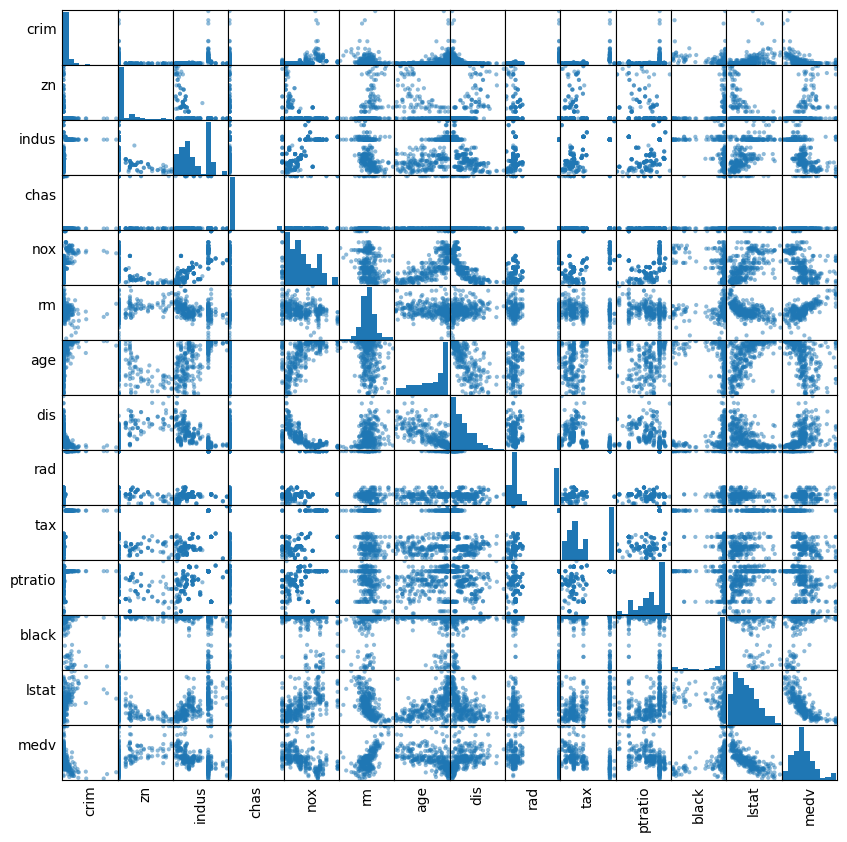

In [13]:
import pandas as pd

numeric_features = [t[0] for t in house_df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = house_df.select(numeric_features).sample(False, 0.8).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

Visual Plotting to determine a rough idea for linar correaltion

### Preparing data two columns-- features and label

In [15]:
from pyspark.ml.feature import VectorAssembler

vectorAssembler = VectorAssembler(inputCols = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'black', 'lstat'], outputCol = 'features')

vhouse_df = vectorAssembler.transform(house_df)

vhouse_df = vhouse_df.select(['features', 'medv'])

In [16]:
vhouse_df.show(3)

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.15876,0.0,10.8...|21.7|
|[0.10328,25.0,5.1...|19.6|
|[0.3494,0.0,9.9,0...|20.3|
+--------------------+----+
only showing top 3 rows



### Splitting dataset to 70% for training and 30% for testing.

In [17]:
splits = vhouse_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

### Linear Regression


In [27]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = 'features', labelCol='medv', maxIter=10, regParam=0.3, elasticNetParam=0.8)

lr_model = lr.fit(train_df)
coefficient123 =  (lr_model.coefficients)
print("Coefficients")
for i in coefficient123:
  print ("              ", i)

print("\nIntercept: " + str(lr_model.intercept))

Coefficients
               -0.0716553529250304
               0.002686521566198324
               -0.02226100607546998
               1.8496042247675442
               -2.2970707187699078
               3.2124620608901497
               0.0
               -0.5363451335489153
               0.0
               0.0
               -0.8577027872755644
               0.007203837763300459
               -0.5769301610614391

Intercept: 26.27356833859256


can be interpreated as
 Y = B₀ + B₁X₁ + B₂X₂ + ... + BₚXₚ + E
 where B₀ is the intercept and rest B₁ .. are coefficent

In [28]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 4.686613
r2: 0.714445


R squared at 0.71 indicates that in our model, approximate 71% of the variability in “medv” can be explained using the model.

In [29]:
train_df.describe().show() #descriptive analysis of traindataset

+-------+------------------+
|summary|              medv|
+-------+------------------+
|  count|               293|
|   mean|22.110238907849837|
| stddev| 8.785294625398535|
|    min|               5.0|
|    max|              50.0|
+-------+------------------+



### Prediction

In [31]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","medv","features").show(10)

from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="medv",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
| 36.55210972082649|50.0|[0.01381,80.0,0.4...|
|30.133193761993102|29.1|[0.01439,60.0,2.9...|
|25.318990853619706|21.6|[0.02731,0.0,7.07...|
| 26.59466873339903|25.0|[0.02875,28.0,15....|
| 26.36986990487886|28.7|[0.02985,0.0,2.18...|
|28.877647640769116|31.2|[0.03049,55.0,3.7...|
|29.507673206843844|33.4|[0.03237,0.0,2.18...|
|31.103013701950342|34.9|[0.03359,75.0,2.9...|
| 25.28554520531868|24.8|[0.03659,25.0,4.8...|
| 33.17025162524598|34.6|[0.03768,80.0,1.5...|
+------------------+----+--------------------+
only showing top 10 rows

R Squared (R2) on test data = 0.735035


### Plotting the predicted vs actual

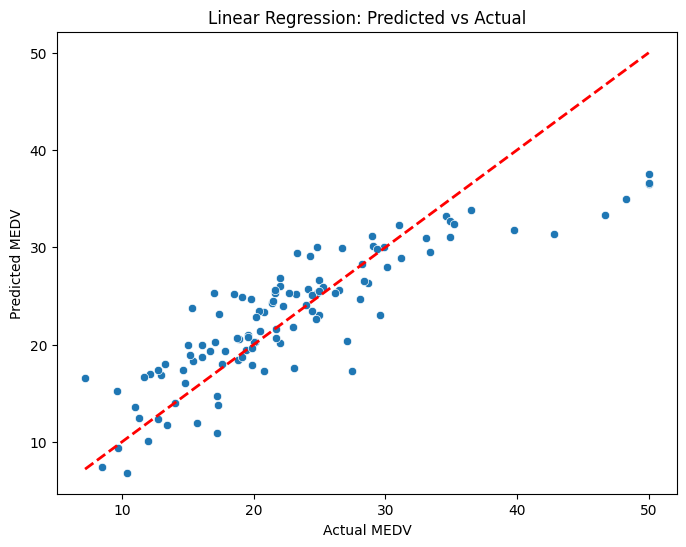

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to Pandas
pdf = lr_predictions.select("prediction", "medv").toPandas()

#  Basic scatter plot (Predicted vs Actual)
plt.figure(figsize=(8,6))
sns.scatterplot(x="medv", y="prediction", data=pdf)

# Add a reference line (perfect prediction line)
plt.plot([pdf.medv.min(), pdf.medv.max()],
         [pdf.medv.min(), pdf.medv.max()],
         color='red', lw=2, linestyle='--')

plt.xlabel("Actual MEDV")
plt.ylabel("Predicted MEDV")
plt.title("Linear Regression: Predicted vs Actual")
plt.show()

Tight cluster near the line = good model fit (low error).
Given plot above is not that bad as our R Squared (R2) on test data = 0.735035

In [37]:

test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 4.60686


In [40]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

numIterations: 10
objectiveHistory: [0.5, 0.43389744163046834, 0.2392497585042151, 0.21577544577291677, 0.18693778238819894, 0.18340843292293624, 0.18198452661265963, 0.18168254957877722, 0.18049245906392888, 0.18042540015749622, 0.18035194359806028]
+-------------------+
|          residuals|
+-------------------+
| -6.825750709210617|
| 1.5138801304747318|
| 2.2445609222264373|
| -2.562375398580482|
| 10.926826724371438|
| 3.8707256956937606|
| 2.8947281120125012|
|-2.4821387103030332|
| 7.5573963738733205|
| 12.880547485683913|
|-1.1116567597552987|
|  7.275105862827758|
| 0.5926162852880275|
| -10.36939137816865|
|-3.3811136137462654|
|  4.007893195425844|
| 2.4246499947742386|
| 1.1450908975039091|
|-1.8249175652356477|
| -3.258199103355789|
+-------------------+
only showing top 20 rows



predictions

In [61]:
predictions = lr_model.transform(test_df)
predictions.select("prediction","medv","features").show()

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
| 36.55210972082649|50.0|[0.01381,80.0,0.4...|
|30.133193761993102|29.1|[0.01439,60.0,2.9...|
|25.318990853619706|21.6|[0.02731,0.0,7.07...|
| 26.59466873339903|25.0|[0.02875,28.0,15....|
| 26.36986990487886|28.7|[0.02985,0.0,2.18...|
|28.877647640769116|31.2|[0.03049,55.0,3.7...|
|29.507673206843844|33.4|[0.03237,0.0,2.18...|
|31.103013701950342|34.9|[0.03359,75.0,2.9...|
| 25.28554520531868|24.8|[0.03659,25.0,4.8...|
| 33.17025162524598|34.6|[0.03768,80.0,1.5...|
|26.826093368012568|22.0|[0.03932,0.0,3.41...|
|29.983915972995078|24.8|[0.04417,70.0,2.2...|
| 24.64427047014727|19.8|[0.04544,0.0,3.24...|
| 28.25425794384836|28.2|[0.04932,33.0,2.1...|
| 24.00222701831551|22.2|[0.05083,0.0,5.19...|
|26.571701074198643|28.4|[0.05479,33.0,2.1...|
|31.157641908244226|29.0|[0.05561,70.0,2.2...|
|23.035667084940798|29.6|[0.06047,0.0,2.46...|
|31.788609424

### Descision Tree

In [62]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'medv')
dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)
dt_evaluator = RegressionEvaluator(
    labelCol="medv", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)




Root Mean Squared Error (RMSE) on test data = 5.40491


In [63]:
train_df.take(1)

[Row(features=DenseVector([0.0063, 18.0, 2.31, 0.0, 0.538, 6.575, 65.2, 4.09, 1.0, 296.0, 15.3, 396.9, 4.98]), medv=24.0)]

In [64]:
dt_model.featureImportances

SparseVector(13, {0: 0.0035, 1: 0.0048, 2: 0.0037, 4: 0.0035, 5: 0.2358, 6: 0.0719, 7: 0.0831, 9: 0.0152, 10: 0.0238, 11: 0.0229, 12: 0.5316})

In [65]:
house_df.take(1)


[Row(crim=0.15876, zn=0.0, indus=10.81, chas=0.0, nox=0.413, rm=5.961, age=17.5, dis=5.2873, rad=4.0, tax=305.0, ptratio=19.2, black=376.94, lstat=9.88, medv=21.7)]

In my trained decision tree model, the most important feature for predicting medv is lstat (percentage of lower status population) with importance 0.5316, followed by rm (average number of rooms) with importance 0.2358.

This differs from the tutorial where rm was reported as the most important feature
The correlation table shows that lstat has a stronger correlation with medv (-0.74) than rm (0.68). This aligns with the model’s feature importance, where lstat is the top predictor. Features that are more strongly related to the target variable often contribute more to reducing impurity in decision tree splits, which is why they receive higher importance scores.


### Gradient Boost tree regression

In [66]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'medv', maxIter=10)
gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)
gbt_predictions.select('prediction', 'medv', 'features').show(5)

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
|41.416513558681096|50.0|[0.01381,80.0,0.4...|
| 28.47652940560226|29.1|[0.01439,60.0,2.9...|
| 24.58955772893561|21.6|[0.02731,0.0,7.07...|
|27.208019318109763|25.0|[0.02875,28.0,15....|
|31.355046975056045|28.7|[0.02985,0.0,2.18...|
+------------------+----+--------------------+
only showing top 5 rows



In [67]:
gbt_evaluator = RegressionEvaluator(
    labelCol="medv", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 5.21191
